# Sensor radiometric properties comparison btw Landsat 7, 8 and Sentinel 2

Author: Morgane Magnier (morgane.magnier@vattenfall.com)

Copyright © 2024 Magnier Morgane 

This notebook is part of a thesis project. The copyright of the thesis itself belongs to the student Morgane Magnier.  

**Rights and Intellectual Property**:  
- Vattenfall has the right to use the findings, methods, and conclusions of this thesis in its operations.  
- Any material generated within the framework of this thesis that is subject to intellectual property protection (e.g., source code, computer program, design, or invention) belongs to Vattenfall, unless otherwise agreed in writing.  

Permission is granted to view, copy, and share this notebook for **educational or personal purposes only**, provided that this notice is included in all copies.  

---

In [ ]:
import ee, geemap, eemont
import geemap.colormaps as cm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# Comparaison entre composite

In [3]:
roi = ee.Geometry.Polygon([[[17.20768,60.41953],[17.237892,60.41953],[17.237892,60.445916],[17.20768,60.445916],[17.20768,60.41953]]])

In [4]:
start_date_l8 = '2019-05-01'
end_date_l8 = '2019-10-31'

l8_col_raw = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date_l8, end_date_l8).filterBounds(roi).filter(ee.Filter.lessThan('CLOUD_COVER', 50)).scale().spectralIndices('NDVI')

l8_col_filtered = l8_col_raw.filter(ee.Filter.calendarRange(5, 10, 'month'))
l8_col_clip = l8_col_filtered.map(lambda image : image.clip(roi))

display(l8_col_clip)

l8_img = l8_col_clip.median()

visualization = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],'min': 0.0,'max': 0.1}

m = geemap.Map()
m.centerObject(roi, 14)

m.addLayer(l8_img, visualization, 'Image random')
m

Map(center=[60.43272206977294, 17.222786000000426], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
start_date = '2021-05-01'
end_date = '2021-10-31'

s2_col_raw = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(roi).filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).scale().spectralIndices('NDVI')

s2_col_filtered = s2_col_raw.filter(ee.Filter.calendarRange(5, 10, 'month'))
s2_col_clip = s2_col_filtered.map(lambda image : image.clip(roi))

display(s2_col_clip)

s2_img = s2_col_clip.median()
display(s2_img)
visualization = {'bands': ['B4', 'B3', 'B2'],'min': 0.0,'max': 0.1}

m = geemap.Map()
m.centerObject(roi, 14)

m.addLayer(s2_img, visualization, 'Image random')
m

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


Map(center=[60.43272206977294, 17.222786000000426], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
def get_index_arrays(image, index_names, roi, scale):
    index_arrays = {}
    for index_name in index_names:
        index_image = image.select(index_name)
        index_stats = index_image.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=scale
        )
        index_values = index_stats.get(index_name).getInfo()
        index_arrays[index_name] = np.array(index_values)
    return index_arrays

# Exemple d'utilisation :
index_names = ['NDVI']
scale = 50

l8_ndvi_array = np.array(get_index_arrays(l8_img, index_names, roi, scale)['NDVI'])
s2_ndvi_array = np.array(get_index_arrays(s2_img, index_names, roi, scale)['NDVI'])


In [7]:
l8_ndvi_array

array([0.83038191, 0.83300052, 0.84668404, ..., 0.802533  , 0.802533  ,
       0.83455809])

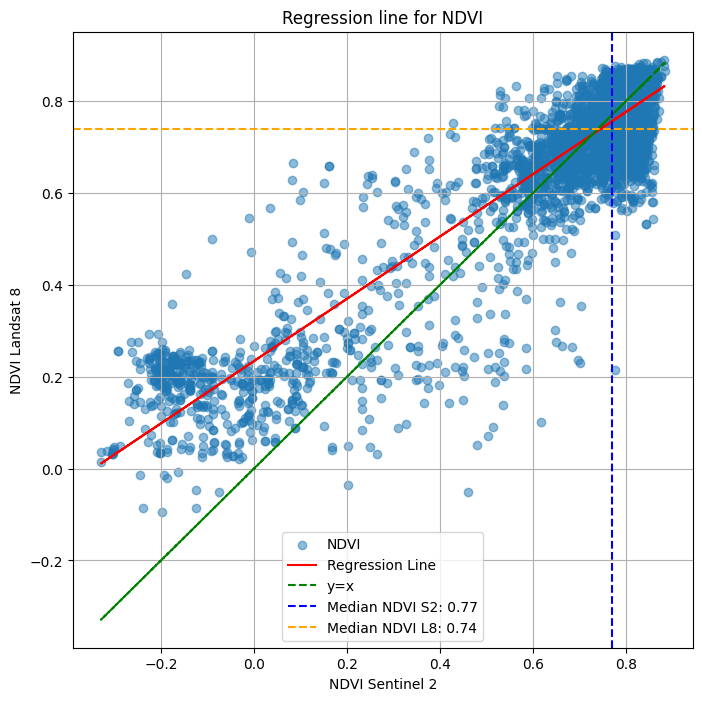

In [8]:
import ee
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Fonction pour tracer la régression linéaire entre deux tableaux
def plot_regression(x, y, label):
    # Calculer la régression linéaire
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Tracer les points avec la régression linéaire
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, alpha=0.5, label=label)
    plt.plot(x, intercept + slope*x, color='red', label='Regression Line')
    
    # Tracer la ligne y=x pour référence
    plt.plot(x, x, linestyle='--', color='green', label='y=x')
    
    # Calculer et afficher la médiane
    median_x = np.median(x)
    median_y = np.median(y)
    plt.axvline(median_x, color='blue', linestyle='--', label=f'Median {label} S2: {median_x:.2f}')
    plt.axhline(median_y, color='orange', linestyle='--', label=f'Median {label} L8: {median_y:.2f}')
    
    # Ajouter des titres et des légendes
    plt.title(f'Regression line for {label}')
    plt.xlabel(f'{label} Sentinel 2')
    plt.ylabel(f'{label} Landsat 8')
    plt.grid(True)
    plt.legend()

# Tracer la régression linéaire pour le NDVI entre Landsat 7 et Landsat 8
plot_regression(s2_ndvi_array, l8_ndvi_array, 'NDVI')

# Afficher le graphique
plt.show()

In [10]:
slope, intercept, r_value, p_value, std_err = linregress(s2_ndvi_array, l8_ndvi_array)

In [11]:
print(intercept,slope)

0.23421867138613872 0.678002962070523


# Comparaison entre deux dates similaires

In [5]:
date_model = ee.Date('2019-08-27')
roi = ee.Geometry.Polygon([[[17.20768,60.41953],[17.237892,60.41953],[17.237892,60.445916],[17.20768,60.445916],[17.20768,60.41953]]])

s2_img = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(roi).filterDate(date_model, date_model.advance(1,'day')).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20)).spectralIndices(['NDVI','NDWI']).first()
l8_img = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(roi).filterDate(date_model, date_model.advance(1,'day')).filter(ee.Filter.lessThan('CLOUD_COVER', 20)).spectralIndices(['NDVI','NDWI']).first()

In [23]:
rgbVis = {'bands': ['SR_B4','SR_B3','SR_B2'], 'min': 0 , 'max' : 0.1}
m = geemap.Map()
m.centerObject(roi, 14)
m.addLayer(l8_img.scale().clip(roi), rgbVis, 's2_img')
m


Map(center=[60.43272206977294, 17.222786000000426], controls=(WidgetControl(options=['position', 'transparent_…

## Histogram de la bande 

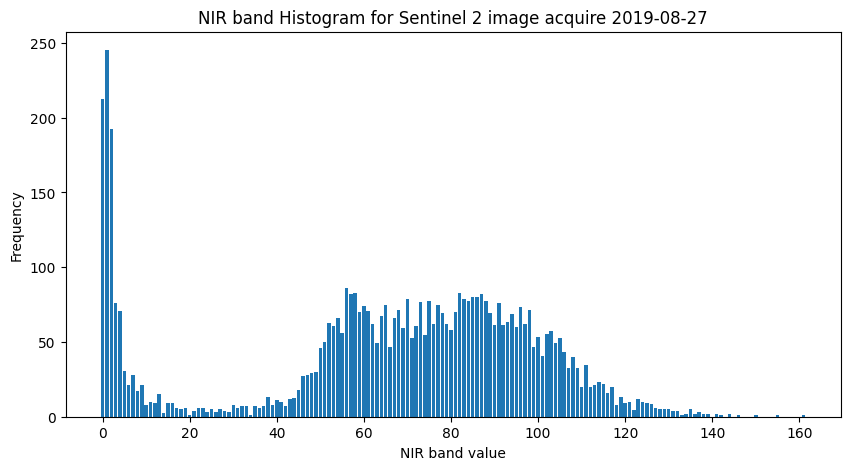

In [18]:
# Obtenir l'histogramme de l'image NDVI seuillée

histogram = s2_img.reduceRegion(
    reducer=ee.Reducer.histogram(255),  # Utilisez 255 bins pour l'histogramme
    geometry=roi,  # Définir la région d'intérêt si nécessaire
    scale=30,  # Échelle de résolution (mètres par pixel)
    #maxPixels=1e9  # Maximum de pixels à utiliser pour le calcul
)

# Extraire les valeurs de l'histogramme
hist_values = histogram.get('B8').getInfo()

# Plot de l'histogramme
plt.figure(figsize=(10, 5))
plt.bar(range(len(hist_values['histogram'])), hist_values['histogram'])
plt.title('NIR band Histogram for Sentinel 2 image acquire 2019-08-27')
plt.xlabel('NIR band value')
plt.ylabel('Frequency')
plt.show()